# Political and socio-economic factors that determine financial outcome of successful green innovation

This jupyter notebook illustrates the data analysis for the paper "Political and socio-economic factors that determine  financial outcome of successful green innovation" into very detail and makes our analysis reproducible.

The analysis took place in folllowing steps (workflow):
1. Initial Descriptive Statistics
2. Data Preparation
3. Multicollinearity Analysis
4. Factor Analysis
5. Regression Analysis (in R)
6. Analysis of Results from Regression Analysis
7. Visualisation of Regression Results and Descriptive Statistics
8. Country Index Analysis

### Imports & Function Definition

In [32]:
# =============================================================================
# ###### Imports
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import kurtosis, skew, f
from sklearn.ensemble import IsolationForest
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

In [33]:
# =============================================================================
# ###### DESCRIPTIVE STATISTICS
# =============================================================================

def getDescriptiveStatistics(desc_df, relevant_columns):
    for col in relevant_columns:
        desc_df[[col]] = desc_df[[col]].apply(pd.to_numeric)
    desc_df_cols = relevant_columns
    stats_table = []
    for sel_column in desc_df_cols:
        values = desc_df[sel_column]
        values.replace([np.inf, -np.inf], np.nan, inplace=True)
        values = values.dropna()
        n    = len(values)
        mean = np.average(values)
        stdd = np.std(values)
        minV = np.min(values)
        maxV = np.max(values)
        curV = kurtosis(values)
        skeV = skew(values)
        q25V = np.percentile(values, 0.25)
        q50V = np.percentile(values, 0.50)
        q75V = np.percentile(values, 0.75)
        stats = ["", sel_column, n, mean, stdd, curV, skeV, minV, q25V, q50V, q75V,  maxV]
        stats_table.append(stats)
    stats_df = pd.DataFrame(stats_table)
    stats_df.columns = ["variable", "abbreviation", "n", "mean", "std", "curtosis", "skewness", "q.00", "q.25", "q.50", "q.75", "q1.0"]
    return stats_df
    
def getDistribution(data_df, by_col, val_col):
    unique_vals = list(data_df[by_col].unique())    
    distribution_stats = []
    for uval in unique_vals:
        values = data_df.loc[data_df[by_col]==uval][val_col]
        values.replace([np.inf, -np.inf], np.nan, inplace=True)
        values = values.dropna()
        distribution_stats.append([uval, len(values), np.min(values), np.average(values),np.max(values),np.std(values)])
    distribution_stats = pd.DataFrame(distribution_stats)
    distribution_stats.columns = ["uval", "n", "min", "mean", "max", "std"]
    return distribution_stats

def calculateDescriptiveStatistics(descriptive_statistics, CAR_NAM):
    # Load Data
    main_df = pd.read_csv("input_data/paper_main_df.csv", sep=",")
    relevant_columns = pd.read_csv("input_data/relevantColumns.txt")["relevant_column"].tolist()
    # Filter Data
    main_df = main_df.loc[main_df[CAR_NAM] >= 0]
    desc_df = main_df[["source_mag", "N_TI_YEAR", "industry", "country", "continent", "CAR", "CAR_CMR", "CAR_MM"]+relevant_columns]
    # Determine aspect specific statistics
    country_stats = getDistribution(desc_df, "country", CAR_NAM)
    contint_stats = getDistribution(desc_df, "continent", CAR_NAM)
    magazin_stats = getDistribution(desc_df, "source_mag", CAR_NAM)
    industr_stats = getDistribution(desc_df, "industry", CAR_NAM)
    yearrrr_stats = getDistribution(desc_df, "N_TI_YEAR", CAR_NAM)
    descriptive_statistics[CAR_NAM] = {}
    descriptive_statistics[CAR_NAM]["country"] = country_stats
    descriptive_statistics[CAR_NAM]["continent"] = contint_stats
    descriptive_statistics[CAR_NAM]["magazine"] = magazin_stats
    descriptive_statistics[CAR_NAM]["industry"] = industr_stats
    descriptive_statistics[CAR_NAM]["year"] = yearrrr_stats
    descriptive_statistics[CAR_NAM][CAR_NAM] = getDescriptiveStatistics(desc_df, [CAR_NAM])

    
    
# =============================================================================
# ###### STATISTICS TESTS
# =============================================================================
def kolmogorov_smirnov_test(dataFrame, colName):
    results = stats.kstest(dataFrame[colName].dropna(), 'norm')
    # Nullhypothesis: Normally distributed
    # Interpretation: Smaller p-value means stronger evidence for alternative 
    return {"KS-Statistic":results[0], "P-Value":results[1]}

def doBartlettTest(df, title):
    print(">>Bartlet test on ",title)
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    print((chi_square_value, p_value))

def doKMOTest(df, title):
    print(">>Kaiser-Meyer_Olkin test on ",title)
    kmo_all,kmo_model=calculate_kmo(df)
    print(kmo_model)
#    print(kmo_all)

def doF_Test(yT, yE, n_factors):
    ytrue = yT
    yesti = yE
    sel = np.isnan(ytrue)
    ytrue = ytrue[~sel]
    yesti = yesti[~sel]
    sel = np.isnan(yesti)
    ytrue = ytrue[~sel]
    yesti = yesti[~sel]
    SQE = np.sum(np.power(yesti-np.mean(np.nan_to_num(yesti)),2))
    SQR = np.sum(np.power(ytrue-yesti,2))
    k = n_factors
    n = yesti.shape[0]
    p = k-1
    MQE = SQE/k
    MQR = SQR/(n-p)
    F=MQE/MQR
    p=1-scipy.stats.f.cdf(F,k,n)
    return [F, k, n, p]



# =============================================================================
# ###### TRANSFORMATION FUNCTIONS
# =============================================================================
def normalizeColumns(df_in):
    for col in list(df_in.columns):
        values = list(df_in[col])
        average = np.average(values)
        stdvals = np.std(values)
        df_in[col] = df_in[col].apply(lambda x: (x-average)/stdvals)
    return df_in



# =============================================================================
# ###### DISPLAY FUNCTIONS
# =============================================================================
def displayCorrelationHeatmap(dataFrame, annot=False):
    correlationmatrix = dataFrame.corr()
    displayHeatmap(correlationmatrix, annot, -1, 1)

def displayHeatmap(dataFrame, annot, minV, maxV):
    sns.heatmap(dataFrame, annot=annot, vmin=minV, vmax=maxV)

def sortVals(labelsMM, labelsCMR, data):
    data2 = []
    for lab in labelsMM:
        idx = labelsCMR.index(lab)
        data2.append(data[idx])
    return data2

def drawBarBlot(data, title, legend=False, sort=True, reverse=False):
    # Get Data
    labelsMM  = list(descriptive_statistics["CAR_MM"][data]["uval"])
    labelsCMR = list(descriptive_statistics["CAR_MM"][data]["uval"])
    labels = labelsMM
    print(labels)
    CARs_CMR = list(descriptive_statistics["CAR_CMR"][data]["mean"])
    CARs_MM  = list(descriptive_statistics["CAR_MM"][data]["mean"])
    ns_MM = list(descriptive_statistics["CAR_MM"][data]["n"])
    CARs_CMR = sortVals(labelsMM, labelsCMR, CARs_CMR)
    # Sort Data
    if(sort):
        labels   = [x for _,x in sorted(zip(CARs_MM, labels))]
        ns_MM    = [x for _,x in sorted(zip(CARs_MM, ns_MM))]
        CARs_CMR = [x*100 for _,x in sorted(zip(CARs_MM, CARs_CMR))]
        CARs_MM  = [x*100 for x in sorted(CARs_MM)]
    else:
        if(reverse):
            labels.reverse()
            CARs_CMR.reverse()
            ns_MM.reverse()
            CARs_MM.reverse()
        CARs_CMR = [x*100 for x in CARs_CMR]
        CARs_MM  = [x*100 for x in CARs_MM]
    x_pos = np.arange(len(labels))
    # Plot Data
    plt.gca().bar(x_pos-0.1, CARs_CMR, color="c", align='center', width=0.2, capsize=10, label="CMR")
    plt.gca().bar(x_pos+0.1, CARs_MM,  color="g", align='center', width=0.2, capsize=10, label="MM")
    for i, v in enumerate(CARs_MM):
        plt.gca().text(x_pos[i], v+0.1, '{:,}'.format(ns_MM[i]), color='gray', rotation=45, fontsize=8)
    plt.gca().set_xticks(x_pos)
    plt.xticks(rotation=35, ha="right")
    plt.gca().set_xticklabels(labels)
    plt.ylim(0,5)
    plt.gca().yaxis.grid(False)
    plt.gca().set_ylabel('CARs (in %)')
    plt.gca().set_title(title)
    if(legend):
        plt.gca().legend()
    plt.tight_layout()
    plt.show()

def getSignificance(val):
    if(val<0.01):
        return "***"
    elif(val<0.05):
        return "**"
    elif(val<0.1):
        return "*"
    else:
        return ""
def convertFloatToStr(val,n=4):
    if(not "e" in str(val)):
        return ("%."+str(n)+"f") % val
    else:
        return str(val)
def getDisplayCoefficient(key, var):
    idx = list(coefficients[key]["var"]).index(var)
    return convertFloatToStr(coefficients[key]["coeff"][idx])+" ("+convertFloatToStr(coefficients[key]["stderror"][idx])+")"+getSignificance(coefficients[key]["pval"][idx])
def getDisplayCoefficientR(key, idx):
    return convertFloatToStr(contributions[key]["coeff"][idx])+" ("+convertFloatToStr(contributions[key]["stderror"][idx])+")"+getSignificance(contributions[key]["pval"][idx])

def getDisplayF1(key):
    return convertFloatToStr(ftests[key][0], n=4)+getSignificance(ftests[key][3])
def getDisplayF2(key):
    return "("+str(ftests[key][1])+", "+str(ftests[key][2])+")"
    
    

# =============================================================================
# ###### R OUTPUT INTERPRETATION
# =============================================================================
def extractProtocoll(lines, topic):
    linesSel = []
    found = False
    for l in lines:
        if(found):
            if(l.startswith("[1] \"###")):
                break
            else:
                linesSel.append(l.replace("\n",""))
        elif(l.startswith("[1] \"### "+topic)):
            found = True
    return linesSel

def getRegressionTable(lines, n):
    linesSel = []
    for l in lines:
        if(l.startswith("(Intercept)") or l.startswith("X")):
            linesSel.append(l)
        if(len(linesSel)>1 and l==""):
            break
    for i in range(0,len(linesSel)):
        while("  " in linesSel[i]):
            linesSel[i] = linesSel[i].replace("  ", " ")
        linesSel[i] = linesSel[i].split(" ")[:3]
        for j in range(1,3):
            linesSel[i][j] = float(linesSel[i][j])
    linesSel = pd.DataFrame(np.asarray(linesSel), columns=["var", "coeff", "stderror"])
    linesSel["coeff"] = pd.to_numeric(linesSel["coeff"])
    linesSel["stderror"] = pd.to_numeric(linesSel["stderror"])
    linesSel["tval"] = linesSel["coeff"]/linesSel["stderror"]
    linesSel["pval"] = linesSel["tval"].apply(lambda x: stats.t.sf(np.abs(x), n-1)*2)
    return linesSel



# =============================================================================
# ###### ANALYSIS FUNCTIONS
# =============================================================================
def getRSquared(yi, yp):
    return 1-(np.sum(np.power(yi-yp,2)))/(np.sum(np.power(yi-np.mean(yi),2)))

def getAdRSquared(yi, yp, n_factors):
    Rsquared = getRSquared(yi, yp)
    return 1-(1-Rsquared)*(yi.shape[0]-1)/(yi.shape[0]-(n_factors+1))

def analyseVariableContribution(loadingsMAT, coefficients, model, n_factors):
    cotnrs = np.matmul(np.asarray(loadingsMAT), np.asarray(coefficients[model]["coeff"][1:]))
    errors = np.matmul(np.asarray(loadingsMAT), np.asarray(coefficients[model]["stderror"][1:]))
    tvalues = cotnrs/errors
    pvalues = pd.DataFrame(tvalues).apply(lambda x: stats.t.sf(np.abs(x), n_factors-1)*2)
    summary = np.asarray([list(cotnrs), list(errors), list(tvalues), np.asarray(pvalues.values)[:,0]]).T
    return pd.DataFrame(summary, columns=["coeff", "stderror", "tval", "pval"])

def analyseResiduals(residuals, preds, truts, X_transformed, n_factors):
    res = np.nan_to_num(residuals)
    # Correlation with X analysis
    corr = []
    for i in range(0,n_factors):
        corr.append(np.corrcoef(res, X_transformed[i].values.tolist())[0][1])  
    # Fligner-Killeen Test
    flignerRes = scipy.stats.fligner(res[0:int(len(res)/2)], res[int(len(res)/2):len(res)])
    # Brown Forsynthe / Levene Test
    brownRes = scipy.stats.levene(res[0:int(len(res)/2)], res[int(len(res)/2):len(res)], center='median')
    # Shapiro Wilk Test of Residuals Normal Distributed
    # Kolmogorov Smirnov Test of Residuals Normal Distributed
    # Breusch Pagan Test of Heteroscedascity
    # Goldfeld Quandt Test of Heteroscedascity
    return [stats.shapiro(res)[0], stats.shapiro(res)[1], stats.kstest(res, 'norm')[0], stats.kstest(res, 'norm')[1], 
              sms.het_breuschpagan(res, X_transformed)[0], sms.het_breuschpagan(res, X_transformed)[1],
              sms.het_breuschpagan(res, X_transformed)[2], sms.het_breuschpagan(res, X_transformed)[3],
              sms.het_goldfeldquandt(res, X_transformed)[0], sms.het_goldfeldquandt(res, X_transformed)[1], 
              flignerRes[0], flignerRes[1],
              brownRes[0], brownRes[1],
              max(corr), np.corrcoef(res, np.nan_to_num(preds)),np.corrcoef(res, np.nan_to_num(truts)) ]



## 1. Initial Descriptive Statistics

In [34]:
# =============================================================================
# ###### Descriptive Statistics of abnormal returns (CAR) 
# ###### by different aspects for CMR and MM
# =============================================================================
descriptive_statistics = {}
    # CAR_CMR
calculateDescriptiveStatistics(descriptive_statistics, "CAR_CMR")
    # CAR_MM
calculateDescriptiveStatistics(descriptive_statistics, "CAR_MM")


# =============================================================================
# ###### Descriptive Statistics specifically for Regression Analysis
# =============================================================================
# Load Data
main_df = pd.read_csv("input_data/paper_main_df.csv", sep=",")
relevant_columns = pd.read_csv("input_data/relevantColumns.txt")["relevant_column"].tolist()
main_df = main_df[["source_mag", "N_TI_YEAR", "industry", "country", "continent", "CAR", "CAR_CMR", "CAR_MM"]+relevant_columns]

# Data Filtering
main_df = main_df.loc[main_df['CAR'] >= 0]
main_df = main_df.dropna()

# Regressor Data Preparation
X = main_df.drop(["source_mag", "N_TI_YEAR", "industry", "country", "continent", "CAR", "CAR_CMR", "CAR_MM"], axis="columns")

# Regressand Data Preparation
Y = main_df[["CAR_CMR", "CAR_MM"]]
Y["CAR_CMR_norm"] = Y['CAR_CMR'].apply(lambda x: np.sqrt(x)*2)
Y["CAR_MM_norm"] = Y['CAR_MM'].apply(lambda x: np.sqrt(x)*2)

# Outlier Detection
  # Isolation forest, its assumption free, hyperparameter free, very good
isfClassificator = IsolationForest(random_state=0).fit(X)
isfPredictScores = isfClassificator.score_samples(X)
X = X[isfPredictScores>=-0.55]
Y = Y[isfPredictScores>=-0.55]


## =============================================================================
## ###### Descriptive Statistics of Regressand(s) (=Y)
## =============================================================================
descriptive_statistics["CAR_normalized"] = getDescriptiveStatistics(Y, ["CAR_CMR_norm", "CAR_MM_norm"])


## =============================================================================
## ###### Descriptive Statistics of Regressors (=X)
## =============================================================================
descriptive_statistics["X"] = getDescriptiveStatistics(X, list(X.columns))

In [8]:
print(descriptive_statistics)

{'CAR_CMR': {'country':                               uval      n           min      mean       max  \
0   United States of America (USA)  17792  0.000000e+00  0.033221  3.747572   
1                           France   3278  2.260000e-06  0.040237  0.438372   
2                          Germany   8401  5.470000e-07  0.032665  0.558531   
3                          Denmark    589  7.530000e-05  0.028136  0.254965   
4                            Japan   8516  1.660000e-06  0.030573  0.460120   
5                      South Korea   1782  7.450000e-05  0.036120  0.391140   
6              United Kingdom (UK)   1871  2.910000e-05  0.033108  0.348204   
7                           Sweden    733  0.000000e+00  0.031750  0.297571   
8                           Norway    163  2.946210e-04  0.027790  0.165607   
9                           Israel     66  1.242351e-03  0.082646  0.297471   
10                           Italy    536  1.670410e-04  0.036125  0.213775   
11                          

## 2. Data Preparation

In [9]:
# =============================================================================
# ###### Preparation of Data
# =============================================================================
# Regressor Transformation by Log if too large
X["N_EC_OIL_PRIC"] = X["N_EC_OIL_PRIC"].apply(lambda x: np.log(x))
X["N_EC_COA_PRIC"] = X["N_EC_COA_PRIC"].apply(lambda x: np.log(x))
X["N_EC_GAS_PRIC"] = X["N_EC_GAS_PRIC"].apply(lambda x: np.log(x))
X["N_FI_FIN_PRIC"] = X["N_FI_FIN_PRIC"].apply(lambda x: np.log(x))
X["N_FI_FIN_MCAP"] = X["N_FI_FIN_MCAP"].apply(lambda x: np.log(x))
X["N_LO_GDP_TOT"] = X["N_LO_GDP_TOT"].apply(lambda x: np.log(x))
X["N_LO_GDP_PCA"] = X["N_LO_GDP_PCA"].apply(lambda x: np.log(x))
# Normalization
normalizeColumns(X)

,N_EC_OIL_PRIC,N_EC_COA_PRIC,N_EC_GAS_PRIC,N_FI_FIN_PRIC,N_FI_FIN_MCAP,N_FI_FIN_EBIT,N_LO_GDP_TOT,N_LO_GDP_PCA,I_LO_CTGCI,I_LO_WWGI_VOI,...,ipri-overall_Overall,ipri-overall_LegalandPolitical,ipri-overall_Physical,ipri-overall_Intellectual,ipri-physical_RuleofLaw,ipri-physical_PoliticalStability,ipri-physical_ControlofCorruption,OECD_EPS,OECD_RND_PC,OECD_PUB_RND
5265,-1.615743,-1.680077,-1.426454,2.449032,-1.145355,-0.267151,0.191483,-0.327283,1.142561,1.237058,...,-0.332003,0.595524,-1.122583,-0.486098,0.740181,0.569373,1.090036,0.020254,0.253424,0.020254
5271,-1.615743,-0.403864,0.005464,-0.232839,-0.874471,-0.802727,1.154723,-2.200797,-0.246734,-1.500278,...,1.273730,0.522566,1.265020,1.660758,-0.543635,0.856465,0.375687,0.097301,0.881008,0.097301
5275,-1.615743,-0.403864,0.005464,-0.232839,-0.874471,-0.802727,1.154723,-2.200797,-0.246734,-1.500278,...,1.273730,0.522566,1.265020,1.660758,-0.543635,0.856465,0.375687,0.097301,0.881008,0.097301
5277,-1.615743,-1.680077,-1.426454,-1.305825,-0.731838,-0.448139,0.191483,-0.327283,1.142561,1.237058,...,-0.332003,0.595524,-1.122583,-0.486098,0.740181,0.569373,1.090036,0.020254,0.253424,0.020254
5284,-1.615743,-1.680077,-1.426454,2.448234,-1.145355,-0.267151,0.191483,-0.327283,1.142561,1.237058,...,-0.332003,0.595524,-1.122583,-0.486098,0.740181,0.569373,1.090036,0.020254,0.253424,0.020254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93328,0.778288,-0.299221,0.139044,0.801526,0.953688,-0.116214,-0.025595,0.897929,-0.174874,1.173399,...,0.071600,0.749859,0.015901,-0.458633,0.643583,0.163756,0.667921,-0.037531,0.053431,-0.037531
93330,0.778288,-0.299221,0.139044,0.193240,1.272471,2.826403,-1.269763,0.341018,-1.133009,-0.036121,...,-1.664328,-1.214406,-1.411665,-1.374137,0.020372,-1.153181,-0.414426,0.867770,-1.171331,0.867770
93337,0.778288,0.870722,1.511039,-1.052227,-2.891763,-0.975869,1.005664,-0.543240,-0.941382,-0.736370,...,0.071600,-0.091969,0.372792,0.456871,-1.537657,0.690531,-0.414426,-0.095316,0.959219,-0.095316
93340,0.778288,0.870722,1.511039,-1.586659,-0.864918,-0.776420,1.005664,-0.543240,-0.941382,-0.736370,...,0.071600,-0.091969,0.372792,0.456871,-1.537657,0.690531,-0.414426,-0.095316,0.959219,-0.095316


## 3. Multicollinearity Analysis

                              feature           VIF
0                       N_EC_OIL_PRIC  2.720547e+02
1                       N_EC_COA_PRIC  6.534414e+01
2                       N_EC_GAS_PRIC  3.464944e+02
3                       N_FI_FIN_PRIC  2.210856e+00
4                       N_FI_FIN_MCAP  1.755874e+00
5                       N_FI_FIN_EBIT  2.059906e+00
6                        N_LO_GDP_TOT  4.585915e+02
7                        N_LO_GDP_PCA  1.683731e+01
8                          I_LO_CTGCI  3.581394e+01
9                       I_LO_WWGI_VOI  1.457316e+02
10                      I_LO_WWGI_STA  4.061221e+01
11                      I_LO_WWGI_GOV  4.292606e+01
12                      I_LO_WWGI_REG  4.092127e+02
13                      I_LO_WWGI_LAW  2.012268e+02
14                      I_LO_WWGI_COR  4.254383e+01
15                          I_LO_ADRI  1.315347e+04
16                      I_LO_NCDI_IDV  2.725451e+04
17                      I_LO_NCDI_POW  6.134433e+04
18          

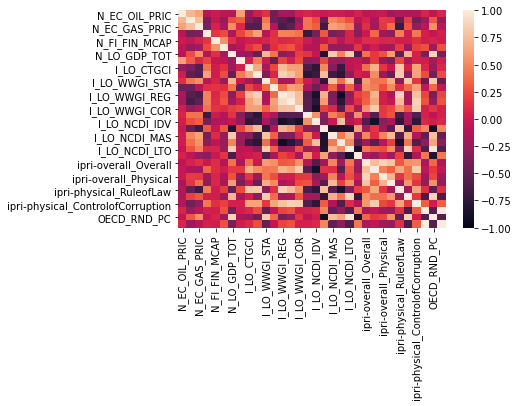

In [13]:

# =============================================================================
# ###### Multicollinearlity Analysis (Result: Multicollinearity Problem Identified)
# =============================================================================
# Check for Problems: Multicollinearity
# Either use correlation matrix
displayCorrelationHeatmap(X)
plt.savefig('output_data/CorrelationMatrix_X.pdf')
plt.close()
displayCorrelationHeatmap(X)

# Or more systematically VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

## 4. Factor Analysis

>>Bartlet test on  X
(1967740.445550399, 0.0)
>>Kaiser-Meyer_Olkin test on  X
0.6178157051580286
KaiserKriterion for Factor Analysis, Determine how many factors
[ 1.10862203e+01  8.20453064e+00  3.02017305e+00  2.69746901e+00
  1.99011739e+00  1.38245521e+00  9.46090855e-01  4.94539774e-01
  4.40308093e-01  3.72557817e-01  3.12205377e-01  2.69163151e-01
  2.34883772e-01  1.26588064e-01  1.11912303e-01  9.43299983e-02
  5.63145062e-02  4.98386361e-02  2.69202808e-02  2.07196792e-02
  1.76433753e-02  1.49947824e-02  1.05204107e-02  6.78656220e-03
  6.71571858e-03  3.27504354e-03  1.28277627e-03  9.24732980e-04
  3.03275289e-04  2.09722615e-04  5.72564988e-06 -3.55298044e-17]
--> Decision for n_factor = 7


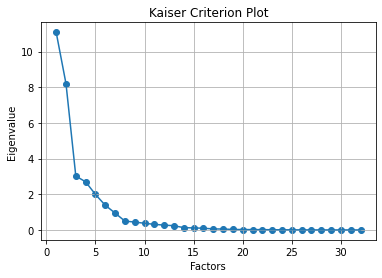



>>FA Loadings = Assignment of Variable to Factor
[[-1.24172585e-01 -1.61244606e-01 -2.24747865e-01  8.61091677e-01
   1.46543848e-01  4.99084695e-02 -1.49147710e-02]
 [-6.07131682e-01 -9.64393067e-02 -7.18557320e-02  6.97276846e-01
  -7.08812163e-02  5.53168966e-02  5.47626090e-02]
 [-7.20879472e-01  3.52316186e-02  3.86731736e-02  5.13444109e-01
   3.54427743e-01 -7.75317622e-03 -4.06158816e-02]
 [ 4.68113726e-01  2.67914084e-01 -4.40062554e-01 -1.34508180e-01
   1.56626563e-01  8.39359406e-02  1.05325633e-01]
 [ 3.79107891e-02  1.42415579e-01  9.10642891e-02  2.28882268e-04
   2.89356367e-01  6.57019720e-01  2.40180584e-01]
 [ 3.29241941e-01 -4.95069469e-02  7.24588078e-02 -1.17991493e-01
   3.70805146e-01  5.86799915e-01  2.24945428e-01]
 [-6.53905624e-01  5.50974473e-01  2.28130936e-02 -9.25875390e-02
   2.06576559e-01  5.33969806e-02 -1.29166387e-01]
 [ 2.25481401e-01 -5.17084777e-02 -5.10063103e-01  6.23384114e-01
  -1.22517174e-02  2.80604600e-02 -9.95638330e-02]
 [ 6.63584599

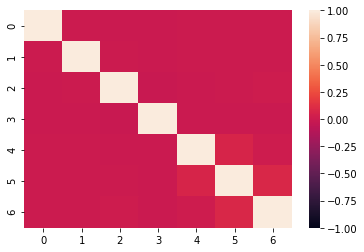

In [18]:
# =============================================================================
# ###### Factor Analysis (Result: Can do Factor Transformation, with 7 factors)
# =============================================================================
# Check for precondition tests for Exploratoy Factor Analysis
    # Bartletts test of sphericity
    # Preconditions: variables intercorrelate at all
doBartlettTest(np.nan_to_num(X), "X")
    # Kaiser-Meyer-Olkin Test
    # Preconditions: suitable of data for factor representation
doKMOTest(np.nan_to_num(X), "X")
    # Kaiser-Criterion to determine Number of Factors
print("KaiserKriterion for Factor Analysis, Determine how many factors")
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(rotation=None)
fa.fit(X)
ev, v = fa.get_eigenvalues()
print(ev)
n_factors = 7
print("--> Decision for n_factor =",n_factors)
plt.scatter(range(1,X.shape[1]+1),ev)
plt.plot(range(1,X.shape[1]+1),ev)
plt.title('Kaiser Criterion Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()
plt.savefig('output_data/KaiserCriterion.pdf')
plt.close()
# Perform Factor Analysis
    # Choose oblimax because best results in decorrelation while highest explained variance
fa = FactorAnalyzer(n_factors, rotation="oblimax")
fa.fit(X)
print("\n")
print(">>FA Loadings = Assignment of Variable to Factor")
print(fa.loadings_)
print(">>FA Variance = Cumulative Var (last row) = variance explained")
print(fa.get_factor_variance())
print(">>FA EigenValues = needs to be normed, then explains how much percent each factor contributes")
ev, v = fa.get_eigenvalues()
print(ev/np.sum(ev))
# Do Transformation into Factor Space
loadingsMAT = np.asarray(fa.loadings_)
X_transformed = pd.DataFrame(np.matmul( X.to_numpy(), loadingsMAT))
descriptive_statistics["X_transformed"] = getDescriptiveStatistics(X_transformed, list(X_transformed.columns))

# Check Multicollinearity Problem in Factor Space again
displayCorrelationHeatmap(X_transformed)
vif_data2 = pd.DataFrame()
vif_data2["feature"] = X_transformed.columns
vif_data2["VIF"] = [variance_inflation_factor(X_transformed.values, i) for i in range(len(X_transformed.columns))]
# Save Results for Regression
data = pd.concat([Y.reset_index(drop=True),X_transformed.reset_index(drop=True)], axis=1)
data.to_csv("temp_data/regression_table_XTr.csv", index=False)



[[-1.24172585e-01 -1.61244606e-01 -2.24747865e-01  8.61091677e-01
   1.46543848e-01  4.99084695e-02 -1.49147710e-02]
 [-6.07131682e-01 -9.64393067e-02 -7.18557320e-02  6.97276846e-01
  -7.08812163e-02  5.53168966e-02  5.47626090e-02]
 [-7.20879472e-01  3.52316186e-02  3.86731736e-02  5.13444109e-01
   3.54427743e-01 -7.75317622e-03 -4.06158816e-02]
 [ 4.68113726e-01  2.67914084e-01 -4.40062554e-01 -1.34508180e-01
   1.56626563e-01  8.39359406e-02  1.05325633e-01]
 [ 3.79107891e-02  1.42415579e-01  9.10642891e-02  2.28882268e-04
   2.89356367e-01  6.57019720e-01  2.40180584e-01]
 [ 3.29241941e-01 -4.95069469e-02  7.24588078e-02 -1.17991493e-01
   3.70805146e-01  5.86799915e-01  2.24945428e-01]
 [-6.53905624e-01  5.50974473e-01  2.28130936e-02 -9.25875390e-02
   2.06576559e-01  5.33969806e-02 -1.29166387e-01]
 [ 2.25481401e-01 -5.17084777e-02 -5.10063103e-01  6.23384114e-01
  -1.22517174e-02  2.80604600e-02 -9.95638330e-02]
 [ 6.63584599e-01  4.52259416e-01 -2.30876019e-02 -2.68809484e-0

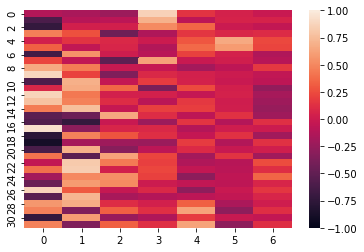

In [22]:

# =============================================================================
# ###### Interpretation of Factor Analysis Results
# =============================================================================
# Understanding meaning of factors based on loadingMAT
print(loadingsMAT)
displayHeatmap(loadingsMAT, False, -1, 1)
plt.savefig('output_data/FactorLoadingsMatrix.pdf')
#plt.close()

## 5. Regression Analysis (in R)

##### ================== BEGIN R SCRIPT ==================

In [ ]:
sink("output_data/r-protocoll-output.txt")

require(foreign)
require(ggplot2)
#install.packages("truncreg")
require(truncreg)
require(boot)
#install.packages("crch")
require(crch)


print("### LoadData")
BigData <- read.csv2("temp_data/regression_table_XTr.csv", header = TRUE, sep =",", dec=".")


print("### Linear Regression on CAR_CMR_norm")
m <- lm(CAR_CMR_norm ~ X0+X1+X2+X3+X4+X5+X6, data =BigData)
print(summary(m))
predictions <- predict(m, BigData)
predictionResult <- data.frame(predictions) 
predictionResult["LM_CAR_CMR_norm"] <- predictionResult["predictions"]


print("### Linear Regression on CAR_MM_norm")
m <- lm(CAR_MM_norm ~ X0+X1+X2+X3+X4+X5+X6, data =BigData)
print(summary(m))
predictions <- predict(m, BigData)
predictionResult["predictions"] <- predictions
predictionResult["LM_CAR_MM_norm"] <- predictionResult["predictions"]


print("### Truncated Regression on CAR_CMR_norm")
m <- truncreg(CAR_CMR_norm ~ X0+X1+X2+X3+X4+X5+X6, data =BigData, point = 0, direction = "left")
print(summary(m))
predictions <- predict(m, BigData)
predictionResult["predictions"] <- predictions
predictionResult["TR_CAR_CMR_norm"] <- predictionResult["predictions"]


print("### Truncated Regression on CAR_MM_norm")
m <- truncreg(CAR_MM_norm ~ X0+X1+X2+X3+X4+X5+X6, data =BigData, point = 0, direction = "left")
print(summary(m))
predictions <- predict(m, BigData)
predictionResult["predictions"] <- predictions
predictionResult["TR_CAR_MM_norm"] <- predictionResult["predictions"]


print("### CRCH Regression on CAR_CMR_norm")
m <- crch(CAR_CMR_norm~X0+X1+X2+X3+X4+X5+X6, data=BigData, point=0, direction="left", dist="student")
summary(m)
predictions <- predict(m, BigData)
predictionResult["predictions"] <- predictions
predictionResult["CR_CAR_CMR_norm"] <- predictionResult["predictions"]


print("### CRCH Regression on CAR_MM_norm")
m <- crch(CAR_MM_norm~X0+X1+X2+X3+X4+X5+X6, data=BigData, point=0, direction="left", dist="student")
summary(m)
predictions <- predict(m, BigData)
predictionResult["predictions"] <- predictions
predictionResult["CR_CAR_MM_norm"] <- predictionResult["predictions"]


print("### Save Predictions to CSV")
predictionResult["CAR_MM_norm"] <- BigData["CAR_MM_norm"]
predictionResult["CAR_CMR_norm"] <- BigData["CAR_CMR_norm"]
predictionResult["predictions"] <- NULL 
write.csv(predictionResult, "output_data/R-predictions.txt", row.names = FALSE)


sink() 

##### ================== END R SCRIPT ==================

## 6. Analysis of Results from Regression Analysis

In [28]:
# =============================================================================
# ###### Get Linear, Truncated and CRC Regression Model Results
# =============================================================================
    # Load Regression Protocoll Output
f = open("output_data/r-protocoll-output.txt","r")
text = f.read()
f.close()
lines = text.split("\n")
    # Determine Coefficients, StdErrors, T-Values and P-Values
coefficients = {}
coefficients["LM_CMR"] = getRegressionTable(extractProtocoll(lines, "Linear Regression on CAR_CMR_norm"), data.shape[0])
coefficients["LM_MM"] = getRegressionTable(extractProtocoll(lines, "Linear Regression on CAR_MM_norm"), data.shape[0])
coefficients["TR_CMR"] = getRegressionTable(extractProtocoll(lines, "Truncated Regression on CAR_CMR_norm"), data.shape[0])
coefficients["TR_MM"] = getRegressionTable(extractProtocoll(lines, "Truncated Regression on CAR_MM_norm"), data.shape[0])
coefficients["CR_CMR"] = getRegressionTable(extractProtocoll(lines, "CRCH Regression on CAR_CMR_norm"), data.shape[0])
coefficients["CR_MM"] = getRegressionTable(extractProtocoll(lines, "CRCH Regression on CAR_MM_norm"), data.shape[0])
    # Load Residuals
predictionsReg = pd.read_csv("output_data/R-predictions.txt", sep=",")
residuals = {}
residuals["LM_CMR"] = np.asarray(predictionsReg["CAR_CMR_norm"]) - np.asarray(predictionsReg["LM_CAR_CMR_norm"])
residuals["LM_MM"] = np.asarray(predictionsReg["CAR_MM_norm"]) - np.asarray(predictionsReg["LM_CAR_MM_norm"])
residuals["TR_CMR"] = np.asarray(predictionsReg["CAR_CMR_norm"]) - np.asarray(predictionsReg["TR_CAR_CMR_norm"])
residuals["TR_MM"] = np.asarray(predictionsReg["CAR_MM_norm"]) - np.asarray(predictionsReg["TR_CAR_MM_norm"])
residuals["CR_CMR"] = np.asarray(predictionsReg["CAR_CMR_norm"]) - np.asarray(predictionsReg["CR_CAR_CMR_norm"])
residuals["CR_MM"] = np.asarray(predictionsReg["CAR_MM_norm"]) - np.asarray(predictionsReg["CR_CAR_MM_norm"])
    # Calculate Rsquares
rsquares = {}
rsquares["LM_CMR"] = getRSquared(predictionsReg["CAR_CMR_norm"], predictionsReg["LM_CAR_CMR_norm"])
rsquares["LM_MM"] = getRSquared(predictionsReg["CAR_MM_norm"], predictionsReg["LM_CAR_MM_norm"])
rsquares["TR_CMR"] = getRSquared(predictionsReg["CAR_CMR_norm"], predictionsReg["TR_CAR_CMR_norm"])
rsquares["TR_MM"] = getRSquared(predictionsReg["CAR_MM_norm"], predictionsReg["TR_CAR_MM_norm"])
rsquares["CR_CMR"] = getRSquared(predictionsReg["CAR_CMR_norm"], predictionsReg["CR_CAR_CMR_norm"])
rsquares["CR_MM"] = getRSquared(predictionsReg["CAR_MM_norm"], predictionsReg["CR_CAR_MM_norm"])
    # Calculate Adjusted RSquares
adrsquares = {}
adrsquares["LM_CMR"] = getAdRSquared(predictionsReg["CAR_CMR_norm"], predictionsReg["LM_CAR_CMR_norm"], n_factors)
adrsquares["LM_MM"] = getAdRSquared(predictionsReg["CAR_MM_norm"], predictionsReg["LM_CAR_MM_norm"], n_factors)
adrsquares["TR_CMR"] = getAdRSquared(predictionsReg["CAR_CMR_norm"], predictionsReg["TR_CAR_CMR_norm"], n_factors)
adrsquares["TR_MM"] = getAdRSquared(predictionsReg["CAR_MM_norm"], predictionsReg["TR_CAR_MM_norm"], n_factors)
adrsquares["CR_CMR"] = getAdRSquared(predictionsReg["CAR_CMR_norm"], predictionsReg["CR_CAR_CMR_norm"], n_factors)
adrsquares["CR_MM"] = getAdRSquared(predictionsReg["CAR_MM_norm"], predictionsReg["CR_CAR_MM_norm"], n_factors)
    # Analyse F Tests
ftests = {}
ftests["LM_CMR"] = doF_Test(predictionsReg["CAR_CMR_norm"], predictionsReg["LM_CAR_CMR_norm"], n_factors)
ftests["LM_MM"] = doF_Test(predictionsReg["CAR_MM_norm"], predictionsReg["LM_CAR_MM_norm"], n_factors)
ftests["TR_CMR"] = doF_Test(predictionsReg["CAR_CMR_norm"], predictionsReg["TR_CAR_CMR_norm"], n_factors)
ftests["TR_MM"] = doF_Test(predictionsReg["CAR_MM_norm"], predictionsReg["TR_CAR_MM_norm"], n_factors)
ftests["CR_CMR"] = doF_Test(predictionsReg["CAR_CMR_norm"], predictionsReg["CR_CAR_CMR_norm"], n_factors)
ftests["CR_MM"] = doF_Test(predictionsReg["CAR_MM_norm"], predictionsReg["CR_CAR_MM_norm"], n_factors)
    # Analyse Contributions of Variables
contributions = {}
contributions["LM_CMR"] = analyseVariableContribution(loadingsMAT, coefficients, "LM_CMR", n_factors)
contributions["LM_MM"] = analyseVariableContribution(loadingsMAT, coefficients, "LM_MM", n_factors)
contributions["TR_CMR"] = analyseVariableContribution(loadingsMAT, coefficients, "TR_CMR", n_factors)
contributions["TR_MM"] = analyseVariableContribution(loadingsMAT, coefficients, "TR_MM", n_factors)
contributions["CR_CMR"] = analyseVariableContribution(loadingsMAT, coefficients, "CR_CMR", n_factors)
contributions["CR_MM"] = analyseVariableContribution(loadingsMAT, coefficients, "CR_MM", n_factors)
    # Residual Analysis
residualAnalysis = {}
residualAnalysis["LM_CMR"] = analyseResiduals(residuals["LM_CMR"], predictionsReg["LM_CAR_CMR_norm"], predictionsReg["CAR_CMR_norm"], X_transformed, n_factors)
residualAnalysis["LM_MM"]  = analyseResiduals(residuals["LM_MM"],  predictionsReg["LM_CAR_MM_norm"],  predictionsReg["CAR_MM_norm"],  X_transformed, n_factors)
residualAnalysis["TR_CMR"] = analyseResiduals(residuals["TR_CMR"], predictionsReg["TR_CAR_CMR_norm"], predictionsReg["CAR_CMR_norm"], X_transformed, n_factors)
residualAnalysis["TR_MM"]  = analyseResiduals(residuals["TR_MM"],  predictionsReg["TR_CAR_MM_norm"],  predictionsReg["CAR_MM_norm"],  X_transformed, n_factors)
residualAnalysis["CR_CMR"] = analyseResiduals(residuals["CR_CMR"], predictionsReg["CR_CAR_CMR_norm"], predictionsReg["CAR_CMR_norm"], X_transformed, n_factors)
residualAnalysis["CR_MM"]  = analyseResiduals(residuals["CR_MM"],  predictionsReg["CR_CAR_MM_norm"],  predictionsReg["CAR_MM_norm"],  X_transformed, n_factors)


## 7. Visualisation of Regression Results and Descriptive Statistics

[2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004]


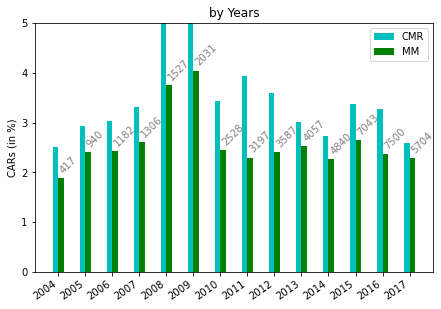

['GreenCarCongress', 'BioBasedNews', 'TechCrunch', 'PhysORG', 'TechXplore', 'CleanTechnica', 'CleanTechies', 'EVObsession', 'Gas2ORG', 'SolarLove']


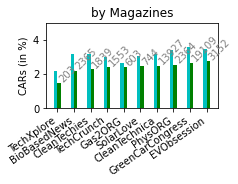

['Vehicle Industry', 'Chem&Biotech', 'Vehicle Industry Suppliers', 'Oil&Gas', 'Electronic', 'Other', 'Aerospace&Defense', 'Telecommunications', 'Energy', 'IT and Internet', 'BasicResources', 'Food&Beverage', 'Retail&Trade', 'Pharma']


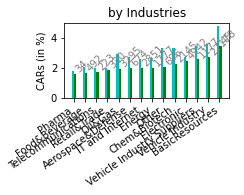

['Europe', 'North America', 'Asia', 'Australia / Oceania', 'South America', 'Africa']


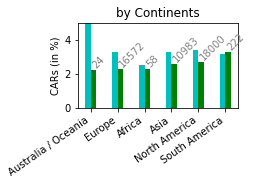

<Figure size 432x288 with 0 Axes>

In [30]:
# =============================================================================
# ###### Visualize Descriptive Statistics
# =============================================================================

plt.gcf().set_size_inches(12, 8)
plt.subplot(2,2,1)
drawBarBlot("year", "by Years", legend=True, sort=False, reverse=True)
plt.subplot(2,2,2)
drawBarBlot("magazine", "by Magazines", legend=False, sort=True)
plt.subplot(2,2,3)
drawBarBlot("industry", "by Industries", legend=False, sort=True)
plt.subplot(2,2,4)
drawBarBlot("continent", "by Continents", legend=False, sort=True)
plt.tight_layout()
plt.savefig('output_data/DescriptiveStatistics.pdf')
plt.show()

In [29]:
# =============================================================================
# ###### Print Coefficients
# =============================================================================
print("\n\nCoefficients")
varss = ["(Intercept)", "X0", "X1", "X2", "X3", "X4", "X5", "X6"]
print("var\t",end="")
for elem in list(coefficients):
    print(elem,"\t", end="")
print()
for var in varss:
    print(var+"\t",end="")
    for elem in list(coefficients):
        print(getDisplayCoefficient(elem,var)+"\t",end="")
    print()

print("\n\nF-Tests")
for elem in list(coefficients):
    print(getDisplayF1(elem),"\t", end="")
print()
for elem in list(coefficients):
    print(getDisplayF2(elem),"\t", end="")
print()

print("\n\nResidual Analysis")
for x in range(0,7):
    for elem in list(coefficients): # Shapiro Wilk Test, Kolmogorov Smirnov, Breusch Pagan LM, Breusch Pagam F, Goldfeld Quandt
        print(convertFloatToStr(residualAnalysis[elem][x*2+0], n=4)+getSignificance(residualAnalysis[elem][x*2+1]),"\t", end="")
    print()
for elem in list(coefficients): # Max Corr with X_Factor
    print(convertFloatToStr(residualAnalysis[elem][14], n=4)+"\t", end="")
print()
for x in range(15,17):
    for elem in list(coefficients): # Corr with Ypred and Ytrue
        print(convertFloatToStr(residualAnalysis[elem][x][0][1], n=4)+"\t", end="")
    print()

print("\n\Reconstructed Coefficients")
print("var\t",end="")
for elem in list(coefficients):
    print(elem,"\t", end="")
print()
for idx in range(0,32):
    print(str(idx)+"\t",end="")
    for elem in list(coefficients):
        print(getDisplayCoefficientR(elem,idx)+"\t",end="")
    print()




Coefficients
var	LM_CMR 	LM_MM 	TR_CMR 	TR_MM 	CR_CMR 	CR_MM 	
(Intercept)	0.3642 (0.0017)***	0.2713 (0.0012)***	0.3533 (0.0020)***	0.2518 (0.0017)***	0.3595 (0.0017)***	0.2632 (0.0012)***	
X0	9.29e-05 (0.0002)	-0.0005 (0.0001)***	0.0001 (0.0002)	-0.0007 (0.0001)***	-3.094e-05 (0.0001)	-0.0006 (0.0001)***	
X1	-0.0018 (0.0002)***	-0.0016 (0.0001)***	-0.0020 (0.0002)***	-0.0019 (0.0002)***	-0.0017 (0.0002)***	-0.0017 (0.0001)***	
X2	-0.0030 (0.0006)***	0.0006 (0.0004)	-0.0035 (0.0006)***	0.0007 (0.0005)	-0.0030 (0.0006)***	0.0006 (0.0004)	
X3	-0.0002 (0.0006)	-0.0021 (0.0005)***	-0.0001 (0.0007)	-0.0024 (0.0006)***	0.0002 (0.0006)	-0.0015 (0.0004)***	
X4	-0.0119 (0.0009)***	-0.0144 (0.0006)***	-0.0134 (0.0010)***	-0.0177 (0.0008)***	-0.0114 (0.0009)***	-0.0133 (0.0006)***	
X5	-0.0228 (0.0014)***	-0.0224 (0.0010)***	-0.0256 (0.0015)***	-0.0279 (0.0012)***	-0.0207 (0.0014)***	-0.0199 (0.0010)***	
X6	0.0096 (0.0019)***	-0.0024 (0.0014)*	0.0106 (0.0021)***	-0.0031 (0.0017)*	0.0097 (0.0019)

## 8. Country Index Analysis

In [36]:
# =============================================================================
# ###### Preparation of Data with Initial Dataset to determine factor loadings 
# ###### and normalization factors
# =============================================================================
# Data Preparation
main_df = pd.read_csv("input_data/paper_main_df.csv", sep=",")
relevant_columns = pd.read_csv("input_data/relevantColumns.txt")["relevant_column"].tolist()
main_df = main_df.loc[main_df['CAR'] >= 0]
main_df = main_df[["source_mag", "N_TI_YEAR", "industry", "country", "continent", "CAR", "CAR_CMR", "CAR_MM"]+relevant_columns]
main_df = main_df.dropna()
# Regressor Data Preparation
X = main_df.drop(["source_mag", "N_TI_YEAR", "industry", "country", "continent", "CAR", "CAR_CMR", "CAR_MM"], axis="columns")
# Regressand Data Preparation
Y = main_df[["CAR_CMR", "CAR_MM"]]
Y["CAR_CMR_norm"] = Y['CAR_CMR'].apply(lambda x: np.sqrt(x)*2)
Y["CAR_MM_norm"] = Y['CAR_MM'].apply(lambda x: np.sqrt(x)*2)
# Outlier Detection
  # Isolation forest, its assumption free, hyperparameter free, very good
isfClassificator = IsolationForest(random_state=0).fit(X)
isfPredictScores = isfClassificator.score_samples(X)
X = X[isfPredictScores>=-0.55]
Y = Y[isfPredictScores>=-0.55]
# Regressor Transformation by Log if too large
X["N_EC_OIL_PRIC"] = X["N_EC_OIL_PRIC"].apply(lambda x: np.log(x))
X["N_EC_COA_PRIC"] = X["N_EC_COA_PRIC"].apply(lambda x: np.log(x))
X["N_EC_GAS_PRIC"] = X["N_EC_GAS_PRIC"].apply(lambda x: np.log(x))
X["N_FI_FIN_PRIC"] = X["N_FI_FIN_PRIC"].apply(lambda x: np.log(x))
X["N_FI_FIN_MCAP"] = X["N_FI_FIN_MCAP"].apply(lambda x: np.log(x))
X["N_LO_GDP_TOT"] = X["N_LO_GDP_TOT"].apply(lambda x: np.log(x))
X["N_LO_GDP_PCA"] = X["N_LO_GDP_PCA"].apply(lambda x: np.log(x))
# Normalization
def normalizeColumns2(df_in):
    factors = {}
    for col in list(df_in.columns):
        values = list(df_in[col])
        average = np.average(values)
        stdvals = np.std(values)
        df_in[col] = df_in[col].apply(lambda x: (x-average)/stdvals)
        factors[col] = {"mean": average, "std": stdvals}
    return df_in, factors
X, norm_factors = normalizeColumns2(X)
# Perform Factor Analysis
    # Choose oblimax because best results in decorrelation while highest explained variance
from factor_analyzer import FactorAnalyzer
n_factors = 7
fa = FactorAnalyzer(n_factors, rotation="oblimax")
fa.fit(X)
loadingsMAT = np.asarray(fa.loadings_)


In [37]:
# =============================================================================
# ###### Preparation of Data for Country Index Analysis
# =============================================================================

# Data Preparation
main_df = pd.read_csv("input_data/paper_main_df.csv", sep=",")
relevant_columns = pd.read_csv("input_data/relevantColumns.txt")["relevant_column"].tolist()
main_df = main_df.loc[main_df['CAR'] >= 0]
main_df = main_df[["source_mag", "N_TI_YEAR", "industry", "country", "continent", "CAR", "CAR_CMR", "CAR_MM"]+relevant_columns]
X = main_df.drop(["source_mag", "N_TI_YEAR", "industry", "country", "continent", "CAR", "CAR_CMR", "CAR_MM"], axis="columns")
Y = main_df[["CAR_CMR", "CAR_MM", "country"]]
Y["CAR_CMR_norm"] = Y['CAR_CMR'].apply(lambda x: np.sqrt(x)*2)
Y["CAR_MM_norm"] = Y['CAR_MM'].apply(lambda x: np.sqrt(x)*2)
X["N_EC_OIL_PRIC"] = X["N_EC_OIL_PRIC"].apply(lambda x: np.log(x))
X["N_EC_COA_PRIC"] = X["N_EC_COA_PRIC"].apply(lambda x: np.log(x))
X["N_EC_GAS_PRIC"] = X["N_EC_GAS_PRIC"].apply(lambda x: np.log(x))
X["N_FI_FIN_PRIC"] = X["N_FI_FIN_PRIC"].apply(lambda x: np.log(x))
X["N_FI_FIN_MCAP"] = X["N_FI_FIN_MCAP"].apply(lambda x: np.log(x))
X["N_LO_GDP_TOT"] = X["N_LO_GDP_TOT"].apply(lambda x: np.log(x))
X["N_LO_GDP_PCA"] = X["N_LO_GDP_PCA"].apply(lambda x: np.log(x))
X = X.fillna(0)
def normalizeColumns3(df_in, norm_factors):
    for col in list(df_in.columns):
        average = norm_factors[col]["mean"]
        stdvals = norm_factors[col]["std"]
        df_in[col] = df_in[col].apply(lambda x: (x-average)/stdvals)
    return df_in
normalizeColumns3(X, norm_factors)

# Do Transformation into Factor Space
X_transformed = pd.DataFrame(np.matmul( X.to_numpy(), loadingsMAT))
descriptive_statistics["X_transformed"] = getDescriptiveStatistics(X_transformed, list(X_transformed.columns))

# Save Results for Regression
data = pd.concat([Y.reset_index(drop=True),X_transformed.reset_index(drop=True)], axis=1)
data.to_csv("temp_data/regression_table_XTr_predictionCountries.csv", index=False)


##### ================== BEGIN R SCRIPT ==================

In [ ]:
sink("output_data/r-protocoll-output_predictionCountries.txt")

require(foreign)
require(ggplot2)
#install.packages("truncreg")
require(truncreg)
require(boot)
#install.packages("crch")
require(crch)


print("### LoadData")
BigData1 <- read.csv2("temp_data/regression_table_XTr.csv", header = TRUE, sep =",", dec=".")
BigData2 <- read.csv2("temp_data/regression_table_XTr_predictionCountries.csv", header = TRUE, sep =",", dec=".")


print("### CRCH Regression on CAR_CMR_norm")
m <- crch(CAR_CMR_norm~X0+X1+X2+X3+X4+X5+X6, data=BigData1, point=0, direction="left", dist="student")
predictions <- predict(m, BigData2)
predictionResult <- data.frame(predictions) 
predictionResult["CR_CAR_CMR_norm"] <- predictionResult["predictions"]


print("### CRCH Regression on CAR_MM_norm")
m <- crch(CAR_MM_norm~X0+X1+X2+X3+X4+X5+X6, data=BigData1, point=0, direction="left", dist="student")
predictions <- predict(m, BigData2)
predictionResult["predictions"] <- predictions
predictionResult["CR_CAR_MM_norm"] <- predictionResult["predictions"]


print("### Truncated Regression on CAR_CMR_norm")
m <- truncreg(CAR_CMR_norm ~ X0+X1+X2+X3+X4+X5+X6, data =BigData1, point = 0, direction = "left")
predictions <- predict(m, BigData2)
predictionResult["predictions"] <- predictions
predictionResult["TR_CAR_CMR_norm"] <- predictionResult["predictions"]


print("### Truncated Regression on CAR_MM_norm")
m <- truncreg(CAR_MM_norm ~ X0+X1+X2+X3+X4+X5+X6, data =BigData1, point = 0, direction = "left")
predictions <- predict(m, BigData2)
predictionResult["predictions"] <- predictions
predictionResult["TR_CAR_MM_norm"] <- predictionResult["predictions"]


print("### Save Predictions to CSV")
predictionResult["predictions"] <- NULL 
write.csv(predictionResult, "output_data/R-predictions_predictionCountries.txt", row.names = FALSE)

sink() 


##### ================== END R SCRIPT ==================

['Germany', 'United States of America (USA)', 'France', 'Denmark', 'Japan', 'South Korea', 'United Kingdom (UK)', 'Sweden', 'Austria', 'Norway', 'Israel', 'Italy', 'China', 'Finland', 'India', 'Belgium', 'Switzerland', 'Russia', 'Netherlands', 'Canada', 'Australia', 'Spain', 'Romania', 'Ireland', 'Portugal', 'Brazil', 'Argentina', 'Colombia', 'Thailand', 'South Africa', 'Turkey', 'Czech Republic']


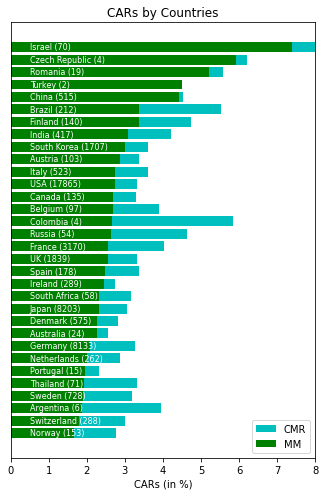

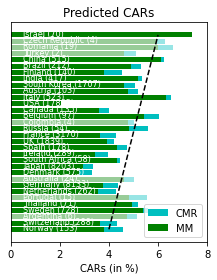

In [39]:
# Load Predictions
predictionsReg = pd.read_csv("output_data/R-predictions_predictionCountries.txt", sep=",")
Xtotlpred = pd.concat([data.reset_index(drop=True), predictionsReg.reset_index(drop=True)], axis=1)

# =============================================================================
# ###### Analyse Regression Prediction
# =============================================================================
countries = list(main_df["country"].unique())

countryIdx_pred = {}
countryIdx_pred["MM"] = {}
countryIdx_pred["CMR"] = {}
for country in countries:
    subdf = Xtotlpred.loc[Xtotlpred["country"]==country]
    datavals = subdf["CR_CAR_CMR_norm"]
    countryIdx_pred["CMR"][country] = np.nan_to_num(np.mean(np.nan_to_num(datavals)))
    datavals = subdf["CR_CAR_MM_norm"]
    countryIdx_pred["MM"][country] = np.nan_to_num(np.mean(np.nan_to_num(datavals)))


# =============================================================================
# ###### Analyse Original Data
# =============================================================================
    
def analyseCountryStats(CAR_NAM):
    main_df = pd.read_csv("input_data/paper_main_df.csv", sep=",")
    relevant_columns = pd.read_csv("input_data/relevantColumns.txt")["relevant_column"].tolist()
    main_df = main_df.loc[main_df[CAR_NAM] >= 0]
    desc_df = main_df[["source_mag", "N_TI_YEAR", "industry", "country", "continent", "CAR", "CAR_CMR", "CAR_MM"]+relevant_columns]
    country_stats = getDistribution(desc_df, "country", CAR_NAM)
    return country_stats
country_statsCMR = analyseCountryStats("CAR_CMR")
country_statsMM = analyseCountryStats("CAR_MM")



# =============================================================================
# ###### Display Results
# =============================================================================

plt.gcf().set_size_inches(4.5*2, 7)


plt.subplot(1,2,1)
# Get Data
labelsMM  = list(country_statsMM ["uval"])
labelsCMR = list(country_statsCMR["uval"])
labels = labelsMM
print(labels)
CARs_CMR = list(country_statsCMR["mean"])
CARs_MM  = list(country_statsMM["mean"])
ns_MM = list(country_statsMM["n"])
CARs_CMR = sortVals(labelsMM, labelsCMR, CARs_CMR)
# Sort Data
labels   = [x for _,x in sorted(zip(CARs_MM, labels))]
labels = [w.replace("United Kingdom (UK)","UK") for w in labels]
labels = [w.replace("United States of America (USA)","USA") for w in labels]
ns_MM    = [x for _,x in sorted(zip(CARs_MM, ns_MM))]
CARs_CMR = [x*100 for _,x in sorted(zip(CARs_MM, CARs_CMR))]
CARs_MM  = [x*100 for x in sorted(CARs_MM)]
x_pos = np.arange(len(labels))
# Plot Data
plt.gca().barh(x_pos, CARs_CMR, color="c", align='center', capsize=10, label="CMR")
plt.gca().barh(x_pos, CARs_MM,  color="g", align='center', capsize=10, label="MM")
for i, v in enumerate(CARs_MM):
    plt.gca().text(0.5, x_pos[i]-0.2, str(labels[i])+" ("+'{:,}'.format(ns_MM[i])+")", color='white', rotation=0, ha="left", size=8)
plt.xlim(0,8)
plt.gca().set_yticklabels(['']*len(labelsMM))
plt.gca().set_yticks([])
plt.gca().set_xlabel('CARs (in %)')
plt.gca().set_title("CARs by Countries")
plt.gca().legend()
plt.tight_layout()
plt.show()


plt.subplot(1,2,2)
# Get Data
labelsMM  = list(country_statsMM ["uval"])
CARs_MM  = list(country_statsMM["mean"])
labelsCI  = list(countryIdx_pred["MM"])
grayBar = []
CARs_CICMR = []
CARs_CIMM = []
for country in labelsCI:
    CARs_CICMR.append(countryIdx_pred["CMR"][country])
    CARs_CIMM.append(countryIdx_pred["MM"][country])
# Sort Data
labelsCI = [x for _,x in sorted(zip(CARs_MM, labelsCI))]
CARs_CICMR = [x*10 for _,x in sorted(zip(CARs_MM, CARs_CICMR))]
CARs_CIMM = [x*10 for _,x in sorted(zip(CARs_MM, CARs_CIMM))]
for i in range(0,len(ns_MM)):
    if(ns_MM[i]>50):
        grayBar.append(0)
    else:
        grayBar.append(8)    
x_pos = np.arange(len(labels))
# Plot Data
plt.gca().barh(x_pos, grayBar, color="white", align='center', alpha=0.6, capsize=10)
plt.gca().barh(x_pos, CARs_CICMR, color="c", align='center', capsize=10, label="CMR")
plt.gca().barh(x_pos, CARs_CIMM, color="g", align='center', capsize=10, label="MM")
plt.gca().barh(x_pos, grayBar, color="white", align='center', alpha=0.6, capsize=10)
for i, v in enumerate(CARs_MM):
    plt.gca().text(0.5, x_pos[i]-0.2, str(labels[i])+" ("+'{:,}'.format(ns_MM[i])+")", color='white', rotation=0, ha="left", size=8)
    
plt.plot([4,6], [min(x_pos), max(x_pos)], color='black', linestyle='dashed')

plt.gca().set_yticklabels(['']*len(labelsMM))
plt.gca().set_yticks([])
plt.gca().set_xlabel('CARs (in %)')
plt.gca().set_title("Predicted CARs")
plt.gca().legend()
plt.xlim(0,8)
plt.tight_layout()
plt.savefig('output_data/CountryStatistics.pdf')
plt.show()